In [129]:
import pandas as pd

In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MultiLabelBinarizer
from  sklearn.impute import KNNImputer


In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
#!pip install pandas openpyxl

In [133]:
path='/content/datafile.xlsx'

In [134]:

#read in data into data_at_admission,hospital_stay
data_at_admission = pd.read_excel(path, sheet_name='Data-at-admission')
hospital_stay = pd.read_excel(path, sheet_name='Hospital-length-of-stay')


In [135]:
data_at_admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                508 non-null    int64  
 1   reason_for_admission              508 non-null    object 
 2   age                               508 non-null    int64  
 3   sex                               508 non-null    object 
 4   ethnicity                         508 non-null    object 
 5   ethnicity_other                   0 non-null      float64
 6   height                            272 non-null    float64
 7   weight                            358 non-null    float64
 8   comorbidities                     508 non-null    object 
 9   comorbidities_other               404 non-null    object 
 10  received_covid_vaccine            1 non-null      object 
 11  covid_vaccine                     0 non-null      float64
 12  medicati

In [136]:
#merging data in different sheets
hospital_df = pd.merge(left=data_at_admission,right=hospital_stay[['parent_id','hospital_length_of_stay']],left_on='id',right_on='parent_id',how='left')
hospital_df.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp,parent_id,hospital_length_of_stay
0,1,Fever [R50.9],74,Male,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""","GERD (gastroesophageal reflux disease), Dement...",NaN,NaN,"""[{\""medications\"":\""TYLENOL EXTRA STRENGTH\"",...",NaN,NaN,No,WARD,99,62,85,20,93,37.5,6.0,4.0,4.0,No,11.0,5.63,132.0,0.406,72.1,23.4,325.0,18.5,128.0,44,14.1,53.0,49.0,165.0,135.0,3.9,10.0,2.3,NaN,NaN,NaN,NaN,NaN,1.1,NaN,NaN,223.0,NaN,1,21
1,2,Pneumonia [J18.9],61,Female,"""[]""",NaN,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""","Closed fracture of fifth metatarsal bone, Dive...",NaN,NaN,"""[{\""medications\"":\""CANDESARTAN\"",\""dosage\"":...",NaN,NaN,No,WARD,122,77,93,36,88,38.0,6.0,5.0,4.0,No,5.0,4.49,121.0,0.353,78.6,26.9,343.0,14.2,236.0,28,12.9,68.0,68.0,49.0,137.0,3.8,12.0,1.5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2354,95.6,NaN,2,5
2,3,Pneumonia [J18.9],58,Female,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\""]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""freq...",NaN,NaN,No,WARD,109,72,73,24,91,38.3,6.0,5.0,3.0,No,6.2,4.31,119.0,0.362,84.0,27.6,329.0,12.5,249.0,NaN,NaN,52.0,76.0,71.0,135.0,3.7,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,7
3,4,Suspected COVID-19 virus infection [U07.2],94,Male,"""[]""",NaN,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostat...",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB...",NaN,NaN,No,WARD,165,71,92,16,96,37.5,6.0,5.0,4.0,No,5.2,4.18,137.0,0.428,102.4,32.8,320.0,17.2,98.0,NaN,NaN,6.0,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,9
4,5,"Febrile respiratory illness [J98.9, R50.9]",91,Male,"""[]""",NaN,NaN,NaN,"""[\""Chronic cardiac disease (not hypertension)...","TAVI, Atrial fibrillation, Gastric Reflux, Pac...",NaN,NaN,"""[{\""medications\"":\""TRAZODONE\"",\""dosage\"":\""...",Ex-smoker,NaN,No,WARD,131,76,60,18,95,38.2,6.0,5.0,4.0,No,4.4,4.65,127.0,0.411,88.4,27.3,309.0,17.6,74.0,NaN,NaN,17.0,26.0,109.0,142.0,3.8,19.0,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,9


In [137]:
hospital_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 57 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                508 non-null    int64  
 1   reason_for_admission              508 non-null    object 
 2   age                               508 non-null    int64  
 3   sex                               508 non-null    object 
 4   ethnicity                         508 non-null    object 
 5   ethnicity_other                   0 non-null      float64
 6   height                            272 non-null    float64
 7   weight                            358 non-null    float64
 8   comorbidities                     508 non-null    object 
 9   comorbidities_other               404 non-null    object 
 10  received_covid_vaccine            1 non-null      object 
 11  covid_vaccine                     0 non-null      float64
 12  medicati

In [138]:
# copied the independent variables given in problem statement
temp = """The variables age, sex, height, weight, comorbidities, systolic_blood_pressure, diastolic_blood_pressure, heart_rate, respiratory_rate, oxygen_saturation, temperature, motor, verbal, eye, wbc, rbc, hemoglobin, hematocrit, mcv, mch, mchc, rdw, platelet_count, aptt_aptr, pt, alt, ast, serum_creatinine, sodium, potassium, total_serum_bilirubin, lactate, pao2, pao2_fio2, ph, high_senstivity_cardiac_troponin, esr, inr, ferritin, d_dimer, crp, hs_crp, intubated, hospital_length_of_stay"""

In [139]:
#splitting the variables into a
variables = temp.split(', ')
variables[0] = 'age'
len(variables)
variables

['age',
 'sex',
 'height',
 'weight',
 'comorbidities',
 'systolic_blood_pressure',
 'diastolic_blood_pressure',
 'heart_rate',
 'respiratory_rate',
 'oxygen_saturation',
 'temperature',
 'motor',
 'verbal',
 'eye',
 'wbc',
 'rbc',
 'hemoglobin',
 'hematocrit',
 'mcv',
 'mch',
 'mchc',
 'rdw',
 'platelet_count',
 'aptt_aptr',
 'pt',
 'alt',
 'ast',
 'serum_creatinine',
 'sodium',
 'potassium',
 'total_serum_bilirubin',
 'lactate',
 'pao2',
 'pao2_fio2',
 'ph',
 'high_senstivity_cardiac_troponin',
 'esr',
 'inr',
 'ferritin',
 'd_dimer',
 'crp',
 'hs_crp',
 'intubated',
 'hospital_length_of_stay']

In [140]:
#filtering the dataframe to required values
hospital_df = hospital_df[variables]

In [141]:
# dropping the columns which has null values more than certain treshold
threshold = 0.3 * 508
hospital_df = hospital_df.dropna(thresh=threshold, axis=1)
hospital_df.head()

,age,sex,height,weight,comorbidities,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,inr,d_dimer,intubated,hospital_length_of_stay
0,74,Male,NaN,NaN,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""",99,62,85,20,93,37.5,6.0,4.0,4.0,11.0,5.63,132.0,0.406,72.1,23.4,325.0,18.5,128.0,44,14.1,53.0,49.0,165.0,135.0,3.9,10.0,2.3,1.1,NaN,No,21
1,61,Female,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""",122,77,93,36,88,38.0,6.0,5.0,4.0,5.0,4.49,121.0,0.353,78.6,26.9,343.0,14.2,236.0,28,12.9,68.0,68.0,49.0,137.0,3.8,12.0,1.5,1.0,2354,No,5
2,58,Female,NaN,NaN,"""[\""Hypertension\""]""",109,72,73,24,91,38.3,6.0,5.0,3.0,6.2,4.31,119.0,0.362,84.0,27.6,329.0,12.5,249.0,NaN,NaN,52.0,76.0,71.0,135.0,3.7,7.0,1.0,NaN,NaN,No,7
3,94,Male,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""",165,71,92,16,96,37.5,6.0,5.0,4.0,5.2,4.18,137.0,0.428,102.4,32.8,320.0,17.2,98.0,NaN,NaN,6.0,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,No,9
4,91,Male,NaN,NaN,"""[\""Chronic cardiac disease (not hypertension)...",131,76,60,18,95,38.2,6.0,5.0,4.0,4.4,4.65,127.0,0.411,88.4,27.3,309.0,17.6,74.0,NaN,NaN,17.0,26.0,109.0,142.0,3.8,19.0,3.2,NaN,NaN,No,9


In [142]:
hospital_df.describe()

,age,height,weight,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,inr,hospital_length_of_stay
count,508.000000,272.000000,358.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.00000,506.000000,506.000000,506.000000,315.000000,403.000000,403.000000,506.000000,506.000000,506.000000,403.000000,362.000000,315.000000,508.000000
mean,66.027559,166.911029,80.265922,129.362205,75.566929,97.397638,24.901575,93.100394,37.768110,5.913043,4.768775,3.944664,8.032609,4.624723,129.875494,0.395055,86.026877,28.28913,328.581028,13.973123,230.934783,14.618095,51.248139,61.399504,114.778656,135.330040,3.885771,10.630273,2.330663,1.159365,12.433071
std,16.394160,10.961776,21.810799,22.051194,12.851352,17.513347,7.170656,6.102006,0.963806,0.462824,0.720213,0.316073,3.744353,0.719621,18.016118,0.051457,7.378936,2.82614,13.493026,1.885807,98.014536,5.378675,51.000029,78.517873,92.014863,5.193653,0.527947,5.697147,1.245724,0.676116,11.902358
min,19.000000,125.000000,27.700000,85.000000,22.000000,41.000000,12.000000,47.000000,35.500000,1.000000,1.000000,1.000000,2.000000,2.780000,74.000000,0.230000,56.700000,17.30000,272.000000,10.300000,19.000000,11.700000,6.000000,11.000000,30.000000,112.000000,2.100000,3.000000,0.600000,0.900000,1.000000
25%,55.750000,159.000000,65.800000,115.000000,68.000000,86.000000,20.000000,92.000000,37.000000,6.000000,5.000000,4.000000,5.500000,4.152500,119.000000,0.362000,82.600000,27.10000,319.000000,12.800000,163.250000,12.900000,25.000000,33.000000,76.000000,133.000000,3.500000,7.000000,1.600000,1.000000,5.000000
50%,66.000000,167.600000,76.700000,127.000000,75.000000,98.000000,24.000000,94.000000,37.700000,6.000000,5.000000,4.000000,7.400000,4.605000,131.000000,0.397000,86.500000,28.70000,330.000000,13.550000,214.000000,13.500000,38.000000,47.000000,95.000000,135.000000,3.900000,9.000000,2.050000,1.000000,8.000000
75%,78.000000,175.000000,89.800000,143.000000,83.000000,109.000000,28.000000,96.000000,38.500000,6.000000,5.000000,4.000000,9.700000,5.050000,142.000000,0.430000,90.300000,30.00000,338.000000,14.600000,276.000000,14.400000,59.000000,68.000000,121.000000,138.000000,4.200000,12.000000,2.700000,1.100000,15.000000
max,100.000000,198.000000,199.600000,227.000000,145.000000,161.000000,59.000000,100.000000,40.500000,6.000000,5.000000,4.000000,33.400000,8.210000,180.000000,0.552000,112.200000,38.20000,382.000000,24.800000,671.000000,72.600000,586.000000,1307.000000,1179.000000,161.000000,6.300000,40.000000,13.800000,8.900000,81.000000


In [143]:
# Convert 'aptt_aptr' and 'd_dimer' columns to numeric
hospital_df['aptt_aptr'] = pd.to_numeric(hospital_df['aptt_aptr'], errors='coerce')
hospital_df['d_dimer'] = pd.to_numeric(hospital_df['d_dimer'], errors='coerce')
hospital_df.info()
hospital_df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       508 non-null    int64  
 1   sex                       508 non-null    object 
 2   height                    272 non-null    float64
 3   weight                    358 non-null    float64
 4   comorbidities             508 non-null    object 
 5   systolic_blood_pressure   508 non-null    int64  
 6   diastolic_blood_pressure  508 non-null    int64  
 7   heart_rate                508 non-null    int64  
 8   respiratory_rate          508 non-null    int64  
 9   oxygen_saturation         508 non-null    int64  
 10  temperature               508 non-null    float64
 11  motor                     506 non-null    float64
 12  verbal                    506 non-null    float64
 13  eye                       506 non-null    float64
 14  wbc       

,0
age,76
sex,2
height,69
weight,203
comorbidities,137
systolic_blood_pressure,100
diastolic_blood_pressure,65
heart_rate,83
respiratory_rate,28
oxygen_saturation,34


In [144]:
# Convert 'sex' column: map male to 1, female to 0
hospital_df['sex'] = hospital_df['sex'].map({'Male': 1, 'Female': 0})

# Convert 'intubated' column: map yes to 1, no to 0
hospital_df['intubated'] = hospital_df['intubated'].map({'Yes': 1, 'No': 0})

# Check if the conversion was successful
hospital_df[['sex', 'intubated']].head()

,sex,intubated
0,1,0
1,0,0
2,0,0
3,1,0
4,1,0


In [145]:
pd.set_option('display.max_columns', None)

In [146]:
hospital_df
df = hospital_df.copy()
df.columns

Index(['age', 'sex', 'height', 'weight', 'comorbidities',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'heart_rate',
       'respiratory_rate', 'oxygen_saturation', 'temperature', 'motor',
       'verbal', 'eye', 'wbc', 'rbc', 'hemoglobin', 'hematocrit', 'mcv', 'mch',
       'mchc', 'rdw', 'platelet_count', 'aptt_aptr', 'pt', 'alt', 'ast',
       'serum_creatinine', 'sodium', 'potassium', 'total_serum_bilirubin',
       'lactate', 'inr', 'd_dimer', 'intubated', 'hospital_length_of_stay'],
      dtype='object')

In [147]:
df.describe()
df.describe(include='all')

,age,sex,height,weight,comorbidities,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,inr,d_dimer,intubated,hospital_length_of_stay
count,508.000000,508.000000,272.000000,358.000000,508,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.00000,506.000000,506.000000,506.000000,287.000000,315.000000,403.000000,403.000000,506.000000,506.000000,506.000000,403.000000,362.000000,315.000000,244.000000,508.000000,508.000000
unique,NaN,NaN,NaN,NaN,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,"""[\""Hypertension\"",\""Other\""]""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,66.027559,0.582677,166.911029,80.265922,NaN,129.362205,75.566929,97.397638,24.901575,93.100394,37.768110,5.913043,4.768775,3.944664,8.032609,4.624723,129.875494,0.395055,86.026877,28.28913,328.581028,13.973123,230.934783,30.912892,14.618095,51.248139,61.399504,114.778656,135.330040,3.885771,10.630273,2.330663,1.159365,1289.987705,0.029528,12.433071
std,16.394160,0.493603,10.961776,21.810799,NaN,22.051194,12.851352,17.513347,7.170656,6.102006,0.963806,0.462824,0.720213,0.316073,3.744353,0.719621,18.016118,0.051457,7.378936,2.82614,13.493026,1.885807,98.014536,6.639788,5.378675,51.000029,78.517873,92.014863,5.193653,0.527947,5.697147,1.245724,0.676116,804.284706,0.169447,11.902358
min,19.000000,0.000000,125.000000,27.700000,NaN,85.000000,22.000000,41.000000,12.000000,47.000000,35.500000,1.000000,1.000000,1.000000,2.000000,2.780000,74.000000,0.230000,56.700000,17.30000,272.000000,10.300000,19.000000,20.000000,11.700000,6.000000,11.000000,30.000000,112.000000,2.100000,3.000000,0.600000,0.900000,277.000000,0.000000,1.000000
25%,55.750000,0.000000,159.000000,65.800000,NaN,115.000000,68.000000,86.000000,20.000000,92.000000,37.000000,6.000000,5.000000,4.000000,5.500000,4.152500,119.000000,0.362000,82.600000,27.10000,319.000000,12.800000,163.250000,27.000000,12.900000,25.000000,33.000000,76.000000,133.000000,3.500000,7.000000,1.600000,1.000000,694.000000,0.000000,5.000000
50%,66.000000,1.000000,167.600000,76.700000,NaN,127.000000,75.000000,98.000000,24.000000,94.000000,37.700000,6.000000,5.000000,4.000000,7.400000,4.605000,131.000000,0.397000,86.500000,28.70000,330.000000,13.550000,214.000000,30.000000,13.500000,38.000000,47.000000,95.000000,135.000000,3.900000,9.000000,2.050000,1.000000,1018.000000,0.000000,8.000000
75%,78.000000,1.000000,175.000000,89.800000,NaN,143.000000,83.000000,109.000000,28.000000,96.000000,38.500000,6.000000,5.000000,4.000000,9.700000,5.050000,142.000000,0.430000,90.300000,30.00000,338.000000,14.600000,276.000000,33.000000,14.400000,59.000000,68.000000,121.000000,138.000000,4.200000,12.000000,2.700000,1.100000,1703.250000,0.000000,15.000000


In [148]:
#data cleaning steps
from  sklearn.impute import KNNImputer

# Step 1: Impute missing values for numerical columns (except for 'aptt_aptr' and 'pt') using the median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Separating columns to apply KNN on 'aptt_aptr' and 'pt' later
knn_cols = ['aptt_aptr', 'pt']
other_num_cols = [col for col in num_cols if col not in knn_cols]

In [149]:
# Median imputation for the remaining numerical columns where there are null values

df[other_num_cols] = df[other_num_cols].fillna(df[other_num_cols].median())

# Step 2: Impute missing values for categorical columns using the mode (most frequent value)




In [150]:
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [151]:



# Using KNN to impute based on correlations with other features
knn_imputer = KNNImputer(n_neighbors=5)

# Impute missing values using KNN for all numerical columns (including 'aptt_aptr' and 'pt')
df[knn_cols] = knn_imputer.fit_transform(df[knn_cols])

# Verify that there are no more missing values in the dataset
null_values_after_imputation = df.isnull().sum()
print("Null values after KNN and median/mode imputation:\n", null_values_after_imputation)

Null values after KNN and median/mode imputation:
 age                         0
sex                         0
height                      0
weight                      0
comorbidities               0
systolic_blood_pressure     0
diastolic_blood_pressure    0
heart_rate                  0
respiratory_rate            0
oxygen_saturation           0
temperature                 0
motor                       0
verbal                      0
eye                         0
wbc                         0
rbc                         0
hemoglobin                  0
hematocrit                  0
mcv                         0
mch                         0
mchc                        0
rdw                         0
platelet_count              0
aptt_aptr                   0
pt                          0
alt                         0
ast                         0
serum_creatinine            0
sodium                      0
potassium                   0
total_serum_bilirubin       0
lactate            

In [152]:
df.describe()

,age,sex,height,weight,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,inr,d_dimer,intubated,hospital_length_of_stay
count,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.00000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000
mean,66.027559,0.582677,167.231102,79.212992,129.362205,75.566929,97.397638,24.901575,93.100394,37.768110,5.913386,4.769685,3.944882,8.030118,4.624646,129.879921,0.395063,86.028740,28.290748,328.586614,13.971457,230.868110,30.832946,14.618071,48.509843,58.423228,114.700787,135.32874,3.885827,10.293307,2.250000,1.098819,1148.639764,0.029528,12.433071
std,16.394160,0.493603,8.021604,18.374419,22.051194,12.851352,17.513347,7.170656,6.102006,0.963806,0.461942,0.718937,0.315468,3.737171,0.718202,17.980686,0.051355,7.364428,2.820678,13.466680,1.882270,97.826782,5.044304,4.233825,45.729307,70.159357,91.841564,5.18344,0.526905,5.115876,1.058827,0.537690,573.186035,0.169447,11.902358
min,19.000000,0.000000,125.000000,27.700000,85.000000,22.000000,41.000000,12.000000,47.000000,35.500000,1.000000,1.000000,1.000000,2.000000,2.780000,74.000000,0.230000,56.700000,17.300000,272.000000,10.300000,19.000000,20.000000,11.700000,6.000000,11.000000,30.000000,112.00000,2.100000,3.000000,0.600000,0.900000,277.000000,0.000000,1.000000
25%,55.750000,0.000000,166.000000,70.700000,115.000000,68.000000,86.000000,20.000000,92.000000,37.000000,6.000000,5.000000,4.000000,5.500000,4.157500,119.000000,0.362000,82.600000,27.100000,319.000000,12.800000,163.750000,28.000000,13.300000,29.000000,37.000000,76.000000,133.00000,3.500000,8.000000,1.800000,1.000000,1018.000000,0.000000,5.000000
50%,66.000000,1.000000,167.600000,76.700000,127.000000,75.000000,98.000000,24.000000,94.000000,37.700000,6.000000,5.000000,4.000000,7.400000,4.605000,131.000000,0.397000,86.500000,28.700000,330.000000,13.550000,214.000000,30.912892,14.618095,38.000000,47.000000,95.000000,135.00000,3.900000,9.000000,2.050000,1.000000,1018.000000,0.000000,8.000000
75%,78.000000,1.000000,168.000000,82.225000,143.000000,83.000000,109.000000,28.000000,96.000000,38.500000,6.000000,5.000000,4.000000,9.700000,5.050000,142.000000,0.430000,90.300000,30.000000,338.000000,14.600000,276.000000,31.000000,14.618095,52.000000,61.000000,121.000000,138.00000,4.200000,11.000000,2.400000,1.100000,1018.000000,0.000000,15.000000
max,100.000000,1.000000,198.000000,199.600000,227.000000,145.000000,161.000000,59.000000,100.000000,40.500000,6.000000,5.000000,4.000000,33.400000,8.210000,180.000000,0.552000,112.200000,38.200000,382.000000,24.800000,671.000000,76.000000,72.600000,586.000000,1307.000000,1179.000000,161.00000,6.300000,40.000000,13.800000,8.900000,3750.000000,1.000000,81.000000


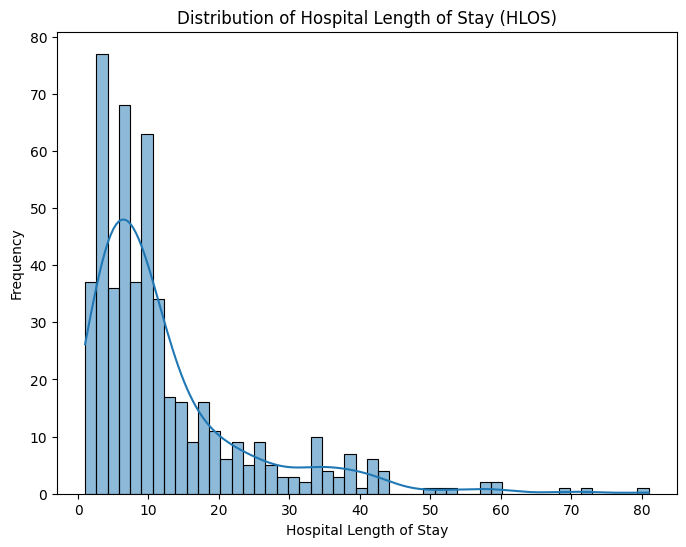

In [153]:
plt.figure(figsize=(8, 6))
sns.histplot(df['hospital_length_of_stay'], bins=50, kde=True)
plt.title('Distribution of Hospital Length of Stay (HLOS)')
plt.xlabel('Hospital Length of Stay')
plt.ylabel('Frequency')
plt.show()


In [154]:
# removing outliers
if df['hospital_length_of_stay'].skew() > 1:
    df['log_hlos'] = np.log1p(df['hospital_length_of_stay'])
    target = 'log_hlos'
else:
    target = 'hospital_length_of_stay'

In [155]:
# cleanind the comorbities feature
df['comorbidities'] = df['comorbidities'].str.replace('[\"\\[\\]\"]', '', regex=True)
df['comorbidities'] = df['comorbidities'].str.split(',')

In [156]:
mlb = MultiLabelBinarizer()
comorbidities_encoded = pd.DataFrame(mlb.fit_transform(df['comorbidities']),
                                     columns=mlb.classes_,
                                     index=df.index)

In [157]:
# concatenating coulumn into the dataframe
df = pd.concat([df, comorbidities_encoded], axis=1)
df.drop('comorbidities', axis=1, inplace=True)

df['age_intubated'] = df['age'] * df['intubated']


In [158]:


corr_matrix = df.corr()

# Select top 15 features with highest correlation to the target
correlations = corr_matrix[target].abs().sort_values(ascending=False)
top_features = correlations[1:18].index.tolist()  # Exclude the target itself

print("Top features selected based on correlation with target:")
print(top_features)

# Step 3: Prepare Features and Target
X = df[top_features]
y = df[target]


Top features selected based on correlation with target:
['hospital_length_of_stay', 'age', '\\Hypertension\\', '', 'platelet_count', 'lactate', 'mcv', 'oxygen_saturation', 'height', '\\Other\\', 'wbc', 'serum_creatinine', 'rbc', 'mch', '\\Dementia any etiology\\', 'total_serum_bilirubin', '\\Kidney disease\\']


In [159]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hospital_length_of_stay  508 non-null    int64  
 1   age                      508 non-null    int64  
 2   \Hypertension\           508 non-null    int64  
 3                            508 non-null    int64  
 4   platelet_count           508 non-null    float64
 5   lactate                  508 non-null    float64
 6   mcv                      508 non-null    float64
 7   oxygen_saturation        508 non-null    int64  
 8   height                   508 non-null    float64
 9   \Other\                  508 non-null    int64  
 10  wbc                      508 non-null    float64
 11  serum_creatinine         508 non-null    float64
 12  rbc                      508 non-null    float64
 13  mch                      508 non-null    float64
 14  \Dementia any etiology\  5

In [160]:


# Calculate the mean, standard deviation, min, max for each column in DataFrame X
mean_values = X.mean()
std_values = X.std()
min_values = X.min()
max_values = X.max()

# Combine the results into a single DataFrame for better visualization
summary_stats = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_values,
    'Min': min_values,
    'Max': max_values
})

# Print the result
print(summary_stats)


                               Mean  Standard Deviation     Min      Max
hospital_length_of_stay   12.433071           11.902358    1.00    81.00
age                       66.027559           16.394160   19.00   100.00
\Hypertension\             0.610236            0.488177    0.00     1.00
                           0.098425            0.298182    0.00     1.00
platelet_count           230.868110           97.826782   19.00   671.00
lactate                    2.250000            1.058827    0.60    13.80
mcv                       86.028740            7.364428   56.70   112.20
oxygen_saturation         93.100394            6.102006   47.00   100.00
height                   167.231102            8.021604  125.00   198.00
\Other\                    0.797244            0.402448    0.00     1.00
wbc                        8.030118            3.737171    2.00    33.40
serum_creatinine         114.700787           91.841564   30.00  1179.00
rbc                        4.624646            0.71

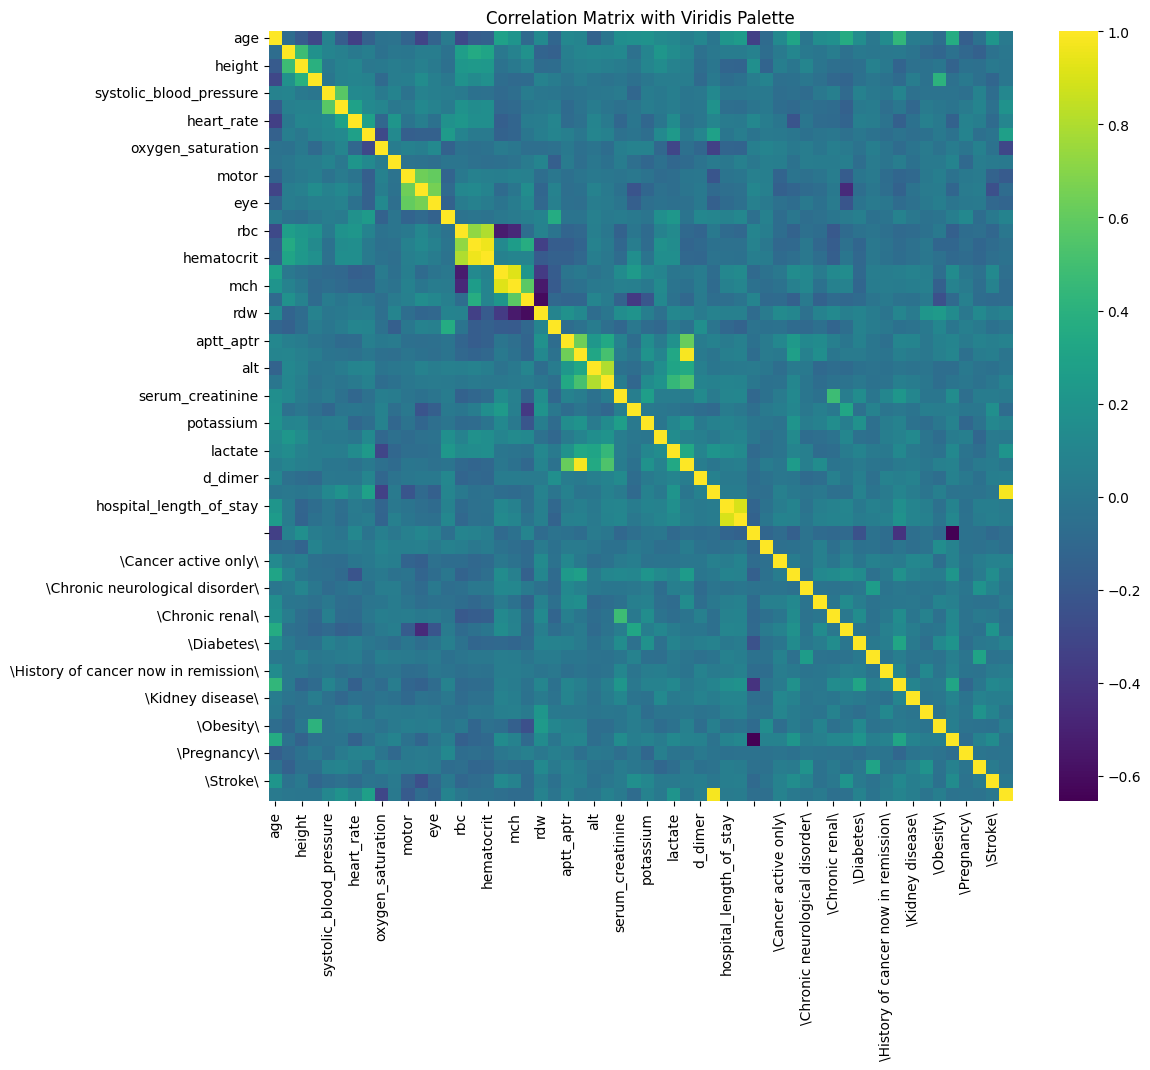

In [161]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='viridis')
plt.title('Correlation Matrix with Viridis Palette')
plt.show()


In [178]:
def calculate_days_left(patient_id, day):
    random_factor = random.randint(1, 10)
    days_left = (30 - day) + random_factor
    return max(0, days_left)

In [162]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# b. Scaling numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [163]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 6: Build the MLP Model with Enhanced Architecture

# Define input
input_dim = X_train.shape[1]
inputs = Input(shape=(input_dim,))

# Hidden Layers with Batch Normalization and Dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output Layer
output = Dense(1, activation='linear')(x)

# Define the model
model = Model(inputs=inputs, outputs=output)

# Compile the model with a suitable optimizer and learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Summary of the model
model.summary()

# Step 7: Train the Model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 17)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 256)                 │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,617 (186.00 KB)

 Trainable params: 46,721 (182.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 8.7359 - mean_squared_error: 8.4496 - val_loss: 5.4431 - val_mean_squared_error: 5.1563
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4989 - mean_squared_error: 7.2120 - val_loss: 5.0233 - val_mean_squared_error: 4.7360
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2030 - mean_squared_error: 5.9157 - val_loss: 4.5843 - val_mean_squared_error: 4.2966
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0048 - mean_squared_error: 5.7170 - val_loss: 4.1734 - val_mean_squared_error: 3.8853
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3859 - mean_squared_error: 5.0977 - val_loss: 3.8349 - val_mean_squared_error: 3.5465
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.3516 - mean_squared_error: 4.0631 - val_loss: 3.4578 - val_mean_squared_error: 3.1691
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.1632 - mean_squared_error: 3.8745 - val_loss: 3.04

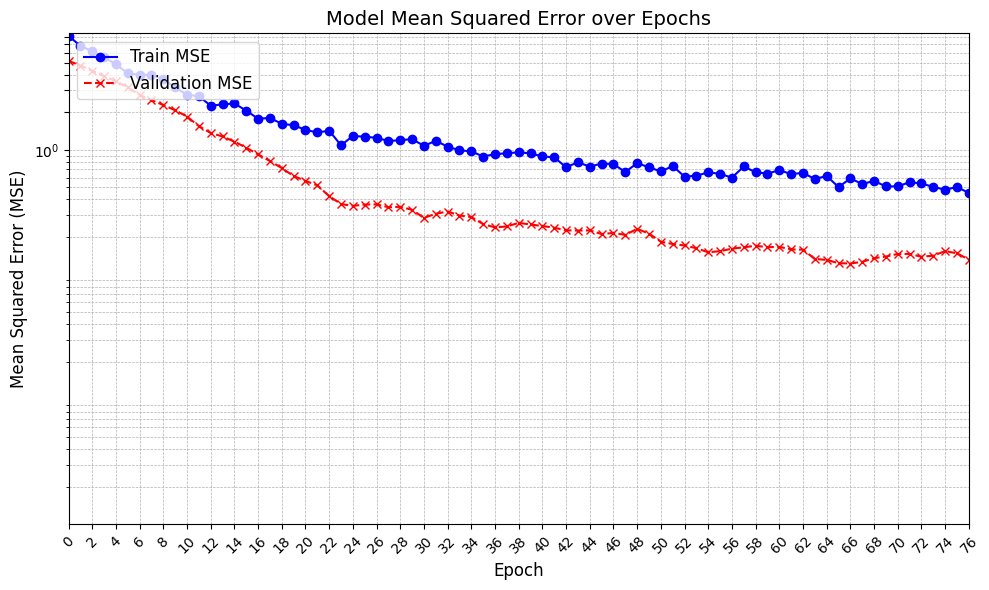

In [164]:
import matplotlib.pyplot as plt

# Plot training and validation MSE values
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data with customized markers, colors, and line styles
ax.plot(history.history['mean_squared_error'], label='Train MSE', color='b', linestyle='-', marker='o')
ax.plot(history.history['val_mean_squared_error'], label='Validation MSE', color='r', linestyle='--', marker='x')

# Set title, labels, and legend
ax.set_title('Model Mean Squared Error over Epochs', fontsize=14)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12)

# Customizing the axes
ax.set_xlim([0, len(history.history['mean_squared_error']) - 1])  # Limit x-axis to the range of epochs
ax.set_ylim(bottom=1e-3)  # Set the y-axis to start from a small value (log scale compatible)

# Set logarithmic scale for y-axis
ax.set_yscale('log')

# Customizing ticks for both axes
ax.xaxis.set_ticks(range(0, len(history.history['mean_squared_error']), 2))  # Tick marks every 2 epochs
ax.yaxis.set_major_locator(plt.MaxNLocator(10))  # Show maximum 10 major ticks on the y-axis

# Adding a grid for readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the legend in the upper left corner
ax.legend(loc='upper left', fontsize=12)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [165]:
y_pred = model.predict(X_test).flatten()

# If log-transformed, inverse transform the predictions
if target == 'log_hlos':
    y_pred = np.expm1(y_pred)
    y_test_actual = np.expm1(y_test)
else:
    y_test_actual = y_test

# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [166]:

r2

0.7880974355482623

In [167]:
mse

26.948144456810713

In [175]:
def mgs(data):
    return [x**2 for x in data if x > 0]  # Squaring positive numbers
result = mgs([1, -2, 3, 4, -5])
print(result)


[1, 9, 16]


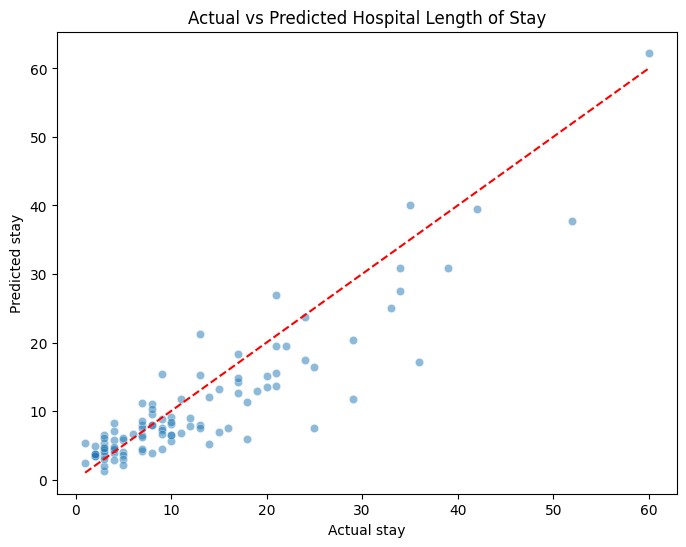

In [177]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_pred, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.title('Actual vs Predicted Hospital Length of Stay')
plt.xlabel('Actual stay')
plt.ylabel('Predicted stay')
plt.show()

In [128]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Initialize KFold cross-validator
#fresh MLP model for each fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []

# Cross-validation loop
for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
    X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]


    inputs = Input(shape=(X_train_cv.shape[1],))
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='linear')(x)

    model_cv = Model(inputs=inputs, outputs=output)

    # Compiling the model
    model_cv.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_cv.fit(X_train_cv, y_train_cv, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    y_pred_cv = model_cv.predict(X_test_cv).flatten()

    if target == 'log_hlos':
        y_pred_cv = np.expm1(y_pred_cv)
        y_test_actual_cv = np.expm1(y_test_cv)
    else:
        y_test_actual_cv = y_test_cv


    mse_cv = mean_squared_error(y_test_actual_cv, y_pred_cv)
    r2_cv = r2_score(y_test_actual_cv, y_pred_cv)


    mse_scores.append(mse_cv)
    r2_scores.append(r2_cv)


    print(f"Fold {fold}: MSE = {mse_cv:.4f}, R² = {r2_cv:.4f}")


print("\nMSE values for each fold:", mse_scores)
print("R² values for each fold:", r2_scores)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Fold 1: MSE = 35.2285, R² = 0.7230
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Fold 2: MSE = 37.3110, R² = 0.7412
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Fold 3: MSE = 20.1407, R² = 0.8192
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Fold 4: MSE = 27.4537, R² = 0.7518
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Fold 5: MSE = 37.0402, R² = 0.8239

MSE values for each fold: [35.228529323246114, 37.31101913698406, 20.14071700680558, 27.45370183251731, 37.040167861987435]
R² values for each fold: [0.7229859103129297, 0.7411631452846109, 0.8191684187345266, 0.7517909956948579, 0.8239049706155601]


In [171]:
# Calculate mean and standard deviation for MSE and R²
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Print the results separately
print(f"Mean MSE: {mean_mse:.4f}")
print(f"Standard Deviation of MSE: {std_mse:.4f}")

print(f"Mean R²: {mean_r2:.4f}")
print(f"Standard Deviation of R²: {std_r2:.4f}")


Mean MSE: 31.4348
Standard Deviation of MSE: 6.6895
Mean R²: 0.7718
Standard Deviation of R²: 0.0417


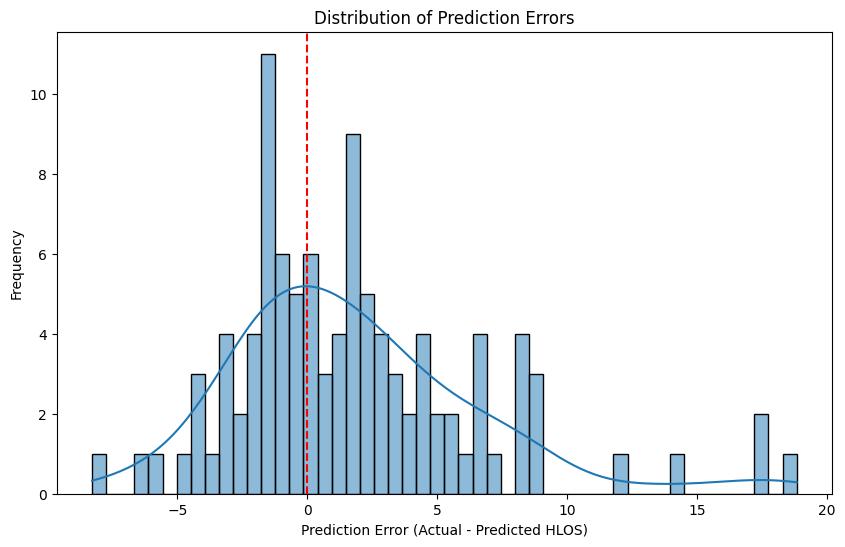

In [173]:
errors = y_test_actual - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Actual - Predicted HLOS)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')  # Line at zero for reference
plt.show()
